###Image Captioning using RNN


### Motivation

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H).

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here!

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make a two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``).

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment).

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [ ]:
# Is MPS even available? macOS 12.3+
print(torch.backends.mps.is_available())

# Was the current version of PyTorch built with MPS activated?
print(torch.backends.mps.is_built())

True
True


In [ ]:
if torch.backends.mps.is_available():
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


**Please refer to the submission section at the top of this notebook to prepare your submission.**


In [ ]:
# Load the feature map provided to you
features_map = torch.load('resnet50_caption.pt', map_location=device)

#### 5 Train DecoderRNN [20 marks]

> 5.1 Design a RNN-based decoder (10 marks)

> 5.2 Train your model with precomputed features (10 Marks)

##### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
import json
import pandas as pd

with open('Downloads/COMP5625M_data_assessment_2/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [ ]:
coco_subset = pd.read_csv("Downloads/COMP5625M_data_assessment_2/coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

,image_id,id,caption,file_name
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
16758,9,663627,there are containers filled with different kin...,000000000009.jpg
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg


In [ ]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
16755,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg,closeup of bins of food that include broccoli ...
16759,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg,a meal is presented in brightly colored plasti...
16758,9,663627,there are containers filled with different kin...,000000000009.jpg,there are containers filled with different kin...
16757,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg,colorful dishes holding meat vegetables fruit ...
16756,9,667602,A bunch of trays that have different food.,000000000009.jpg,a bunch of trays that have different food
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [ ]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:3547, validation:506, test:1015


In [ ]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [ ]:
test_set.head()

,image_id,id,caption,file_name,clean_caption
9634,25,127238,A giraffe mother with its baby in the forest.,000000000025.jpg,a giraffe mother with its baby in the forest
9633,25,127076,A giraffe standing up nearby a tree,000000000025.jpg,a giraffe standing up nearby a tree
9635,25,133058,Two giraffes standing in a tree filled area.,000000000025.jpg,two giraffes standing in a tree filled area
9636,25,133676,A giraffe standing next to a forest filled wit...,000000000025.jpg,a giraffe standing next to a forest filled wit...
9637,25,122312,A giraffe eating food from the top of the tree.,000000000025.jpg,a giraffe eating food from the top of the tree


In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
### build vocabulariy for each set - train, val and test
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2352


In [ ]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

2500

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn.


In [ ]:
from helperDL import EncoderCNN
model = EncoderCNN()
print(model)

/Users/shivamsharma/anaconda3/envs/masters/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shivamsharma/anaconda3/envs/masters/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/shivamsharma/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.8MB/s]


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [ ]:
#''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct)
#features = torch.load("coco_features.pt")

# also load the model ckpt and udate the model state dict of the base model
# ---> your entry here (make sure that the path is correct)
#checkpoint = torch.load("ckpt file here")
#model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [ ]:
# say this is as below
# --> Please change these numbers as required.
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        # your code
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        # compute your feature embeddings
        # your code
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)

        hiddens, _ = self.rnn(packed)


        outputs = self.linear(hiddens[0]) #hint: use a hidden layers in parenthesis
        return outputs


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

In [ ]:
decoder

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embed): Embedding(2500, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2500, bias=True)
)

##### 5.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:

# loss and optimizer here
# your code here --->
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)


# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->
        features_, captions_ = features_.to(device), captions_.to(device)


        optimizer.zero_grad()

        outputs = decoder(features_, captions_, lengths_)


        targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]


        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")

    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->
            features_, captions_ = features_.to(device), captions_.to(device)

            outputs = decoder(features_, captions_, lengths_)

            targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]

            loss = criterion(outputs, targets)

            total_loss += loss.item()

    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

(5, 2)
Epoch [1/5], Step [0/555], Loss: 7.8640
Epoch [1/5], Step [10/555], Loss: 5.7888
Epoch [1/5], Step [20/555], Loss: 5.5692
Epoch [1/5], Step [30/555], Loss: 5.2305
Epoch [1/5], Step [40/555], Loss: 5.0427
Epoch [1/5], Step [50/555], Loss: 4.8383
Epoch [1/5], Step [60/555], Loss: 4.6808
Epoch [1/5], Step [70/555], Loss: 4.7963
Epoch [1/5], Step [80/555], Loss: 4.3106
Epoch [1/5], Step [90/555], Loss: 4.6811
Epoch [1/5], Step [100/555], Loss: 4.1385
Epoch [1/5], Step [110/555], Loss: 4.3019
Epoch [1/5], Step [120/555], Loss: 4.2044
Epoch [1/5], Step [130/555], Loss: 4.0494
Epoch [1/5], Step [140/555], Loss: 3.7476
Epoch [1/5], Step [150/555], Loss: 3.7824
Epoch [1/5], Step [160/555], Loss: 4.1143
Epoch [1/5], Step [170/555], Loss: 3.9107
Epoch [1/5], Step [180/555], Loss: 3.8911
Epoch [1/5], Step [190/555], Loss: 3.6317
Epoch [1/5], Step [200/555], Loss: 3.7468
Epoch [1/5], Step [210/555], Loss: 3.5610
Epoch [1/5], Step [220/555], Loss: 3.5585
Epoch [1/5], Step [230/555], Loss: 3.3

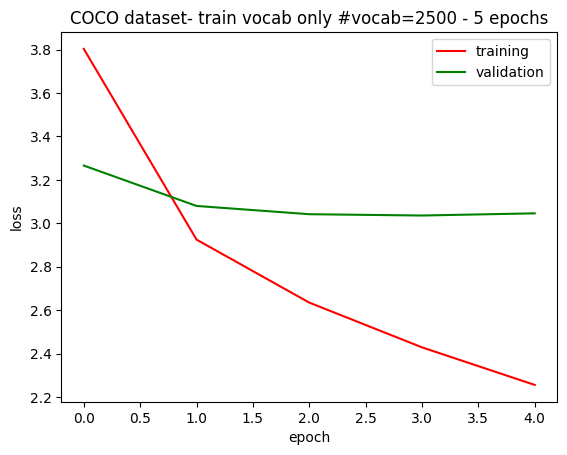

In [ ]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [ ]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation [10 marks]

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.img_dir = 'Downloads/COMP5625M_data_assessment_2/coco/images/'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['file_name'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        filename = os.path.basename(img_path)

        return image, filename

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [ ]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embed): Embedding(2500, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2500, bias=True)
)

In [ ]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

In [ ]:

reference_captions_dict = test_set.groupby('file_name')['caption'].apply(list).to_dict()

def fetch_reference_captions(filename):
    return reference_captions_dict.get(filename, [])


GENERATED: 
 a giraffe standing next to a tall tree branches 

REFERENCES:
A giraffe mother with its baby in the forest.
A giraffe standing up nearby a tree 
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.
A giraffe eating food from the top of the tree.



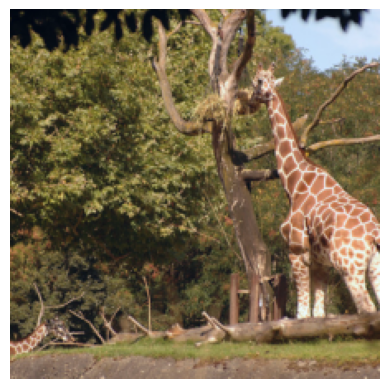

GENERATED: 
 a wooden table topped with a lot of items 

REFERENCES:
A bed sits on top of a dresser and a desk.
Wooden bed on top of a white dresser.
Bunk bed with a narrow shelf sitting underneath it. 
A loft bed with a dresser underneath it.
A bed and desk in a small room.



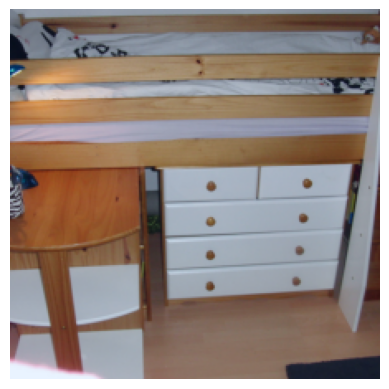

GENERATED: 
 assorted donuts on a plate with a <unk> of <unk> 

REFERENCES:
Various pastries are displayed in a take out box.
A box full of donuts in different shapes and flavors.
A box of chocolate, filled, sour cream donuts.
A big box of various types of doughnuts.
A variety of donuts and pastries in a box.



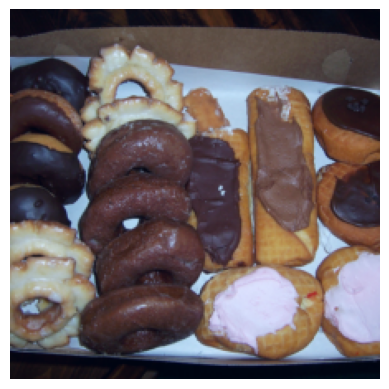

GENERATED: 
 a red and white airplane sitting in the snow 

REFERENCES:
A white and red train traveling over a city.
A red and white train riding through a city on elevated tracks.
A Virgin Mobile train driving in the middle of a city.
A modern commuter train travels through the city
A passenger train that is going over a bridge.



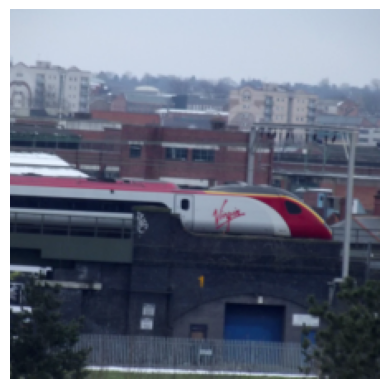

In [ ]:
IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image,filename) in enumerate(test_loader):

        # your code here --->
        image_input = image.to(next(model.parameters()).device)

        features = model(image_input)
        features = features.to(device)
        captions = decoder.sample(features)
        captions = captions.to('cpu')

        captions_list = [word_id.item() for word_id in captions.view(-1)]

        caption_text = decode_caption(captions_list, vocab)


        print(f"GENERATED: \n {caption_text} \n")
        print("REFERENCES:")
        ref_captions = fetch_reference_captions(filename[0])
        for ref_caption in ref_captions:
            print(ref_caption)
        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

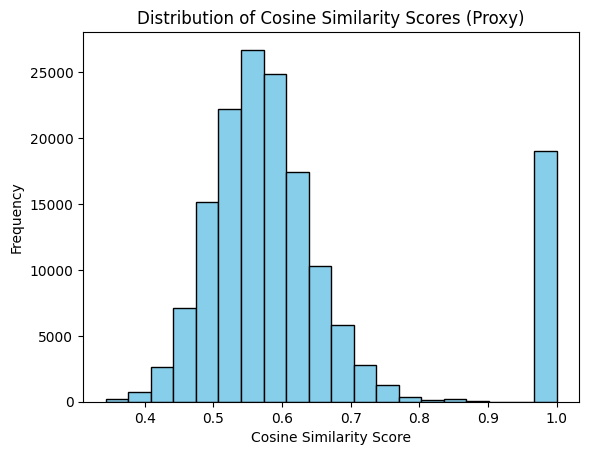

In [ ]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def fetch_reference_captions(filename):
    return reference_captions_dict.get(filename, [])



model = model.to(device).eval()
decoder = decoder.to(device).eval()


cosine_scores = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        features = model(images)


        for i in range(len(features)):

            for j in range(len(features)):
                if i != j:
                    feature_i_cpu = features[i].unsqueeze(0).cpu().numpy()
                    feature_j_cpu = features[j].unsqueeze(0).cpu().numpy()


                    sim_score = cosine_similarity(feature_i_cpu, feature_j_cpu)[0][0]
                    cosine_scores.append(sim_score)


plt.hist(cosine_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores (Proxy)')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.show()
